In [6]:
import time
time_ini=time.time()

In [7]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
comex_df_dum=pd.read_csv('/home/andre301267/git/Pricing-Fertilizer/DB/temp/imp_fert_select.csv')
comex_df_dum.columns

Index(['date', 'kg', 'year~1997', 'year~1998', 'year~1999', 'year~2000',
       'year~2001', 'year~2002', 'year~2003', 'year~2004', 'year~2005',
       'year~2006', 'year~2007', 'year~2008', 'year~2009', 'year~2010',
       'year~2011', 'year~2012', 'year~2013', 'year~2014', 'year~2015',
       'year~2016', 'year~2017', 'year~2018', 'year~2019', 'year~2020',
       'year~2021', 'year~2022', 'year~2023', 'year~2024', 'month~1',
       'month~2', 'month~3', 'month~4', 'month~5', 'month~6', 'month~7',
       'month~8', 'month~9', 'month~10', 'month~11', 'month~12', 'Product~MAP',
       'Product~MOP', 'Product~UREIA', 'oc'],
      dtype='object')

# LOOP

In [8]:
max_features=10
max_depth=10
poly_deg=2

In [9]:
qq=pd.DataFrame()

for rr in range(1,6):

    predict_date=comex_df_dum.date.max()-DateOffset(months=12*rr-1)
    
    train=comex_df_dum[comex_df_dum.date<predict_date]
    test=comex_df_dum[comex_df_dum.date==predict_date]
    
    train.date=train.date.astype(int)
    test.date=test.date.astype(int)
    
    # Classificação
    
    X_train=train.drop(columns=['kg','oc'])
    y_train=train.oc
    X_test=test.drop(columns=['kg','oc'])
    
    from sklearn.ensemble import RandomForestClassifier as RFC
    RFC=RFC()
    RFC.fit(X_train,y_train)
    test=test.assign(oc_pred=RFC.predict(X_test))
    
    # Regressão
    
    train=train[train.oc==1]
    
    test=test[(test.oc==1)&(test.oc_pred==1)]
    
    X_train=train.drop(columns=['kg','oc'])
    y_train=train.kg
    X_test=test.drop(columns=['kg','oc','oc_pred'])
        
    from sklearn.ensemble import RandomForestRegressor as RFR
    RFR=RFR(max_features=max_features, max_depth=max_depth)
    
    from sklearn.linear_model import LinearRegression as LM
    LM=LM()
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.pipeline import make_pipeline
    polynomial_features = PolynomialFeatures(degree=poly_deg)
    LR = make_pipeline(polynomial_features, LM)
    
    RFR.fit(X_train,y_train)
    test=test.assign(kg_test_rfr=RFR.predict(X_test))
    
    LR.fit(X_train,y_train)
    test=test.assign(kg_test_lr=LR.predict(X_test))
    
    ano_dum=test[test.columns[test.columns.str.contains('yaer')]]
    
    mes_dum=test[test.columns[test.columns.str.contains('month')]]
    
    Product_dum=test[test.columns[test.columns.str.contains('Product')]]
    
    w=(ano_dum+mes_dum+Product_dum).columns
    
    outros=test[[x for x in test.columns if x not in w]]
    
    l=[ano_dum,mes_dum,Product_dum]
    
    q1=pd.DataFrame()
    for x in l:
        t=pd.from_dummies(x,sep='~')
        q1=pd.concat([q1,t],axis=1)
    
    test_pred=pd.concat([q1,outros],axis=1)
    
    test_pred[test_pred.columns[test_pred.columns.str.contains('KG')]]=\
    test_pred[test_pred.columns[test_pred.columns.str.contains('KG')]].astype(int)
    
    test_pred.date=test_pred.date.astype('datetime64[ns]')
    
    qq=pd.concat([qq,test_pred])

TypeError: unsupported operand type(s) for -: 'str' and 'DateOffset'

In [16]:
from sklearn import metrics

In [17]:
qqq=pd.DataFrame()
for ww in qq.Product.unique():
    qqt=qq[qq.Product==ww]
    std_lr=round(metrics.mean_squared_error(qqt['kg'],qqt['kg_test_lr'])**(1/2))
    std_rfr=round(metrics.mean_squared_error(qqt['kg'],qqt['kg_test_rfr'])**(1/2))
    std_df=pd.DataFrame({'Product':[ww],'std_lr':[std_lr],'std_rfr':[std_rfr]})
    qqq=pd.concat([qqq,std_df])

print('\n*** Standard deviation (kg) ***\n')
qqq


*** Standard deviation (kg) ***



,nick,std_lr,std_rfr
0,MAP,8290398,3847159
0,MOP,24587676,19004543
0,UREIA,19475151,17765465


# Prediction

### Classification

In [18]:
date_pred=(comex_df[comex_df.date==comex_df.date.max()][['date']].drop_duplicates()+DateOffset(months=1)).assign(key=0)

Product_pred=comex_df[['Product']].drop_duplicates().assign(key=0)

pred=date_pred.merge(Product_pred).drop(columns='key')
pred['yaer']=pred.date.dt.year
pred['month']=pred.date.dt.month

comex_df_pred=pd.concat([comex_df,pred])

comex_df_pred[['month','Product']]=comex_df_pred[['month','Product']].astype('category')
comex_df_pred_dum=pd.get_dummies(comex_df_pred,prefix_sep='~')
comex_df_pred_dum.date=comex_df_pred_dum.date.astype(int)
comex_df_pred_dum.drop(columns='yaer',inplace=True)

train=comex_df_pred_dum[comex_df_pred_dum.date<comex_df_pred_dum.date.max()].assign(oc=0)
train.loc[train.kg>0,'oc']=1

pred=comex_df_pred_dum[comex_df_pred_dum.date==comex_df_pred_dum.date.max()].drop(columns='kg')

X_train=train.drop(columns=['kg','oc'])
y_train=train.oc
X_pred=pred
RFC.fit(X_train,y_train)
pred=pred.assign(oc_pred=RFC.predict(X_pred))

### Regression

In [19]:
train=train[train.oc==1]

In [20]:
pred=pred[pred.oc_pred==1]

In [21]:
X_train=train.drop(columns=['kg','oc'])

In [22]:
y_train=train.kg

In [23]:
X_pred=pred.drop(columns=['oc_pred'])

In [24]:
RFR.fit(X_train,y_train)

RandomForestRegressor(max_depth=10, max_features=10)

In [25]:
pred=pred.assign(kg_pred_rfr=RFR.predict(X_pred))
pred

,date,CO_MES~1,CO_MES~2,CO_MES~3,CO_MES~4,CO_MES~5,CO_MES~6,CO_MES~7,CO_MES~8,CO_MES~9,CO_MES~10,CO_MES~11,CO_MES~12,nick~MAP,nick~MOP,nick~UREIA,oc_pred,KG_LIQUIDO_pred_rfr
0,1725148800000000000,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,1,3.654689e+07
1,1725148800000000000,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,1,8.190165e+07
2,1725148800000000000,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,1,4.689380e+07


In [26]:
LR.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [27]:
pred=pred.assign(kg_pred_lr=LR.predict(X_pred))
pred

,date,CO_MES~1,CO_MES~2,CO_MES~3,CO_MES~4,CO_MES~5,CO_MES~6,CO_MES~7,CO_MES~8,CO_MES~9,CO_MES~10,CO_MES~11,CO_MES~12,nick~MAP,nick~MOP,nick~UREIA,oc_pred,KG_LIQUIDO_pred_rfr,KG_LIQUIDO_pred_lr
0,1725148800000000000,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,1,3.654689e+07,3.281598e+07
1,1725148800000000000,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,1,8.190165e+07,3.281598e+07
2,1725148800000000000,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,1,4.689380e+07,3.281598e+07


In [28]:
mes_d=pd.from_dummies(pred[pred.columns[pred.columns.str.contains('MES')]],sep='~')

In [29]:
Product_d=pd.from_dummies(pred[pred.columns[pred.columns.str.contains('Product')]],sep='~')

In [30]:
o=pred[pred.columns[~((pred.columns.str.contains('MES'))+(pred.columns.str.contains('Product')))]]

In [31]:
pred=pd.concat([o,mes_d,Product_d],axis=1)

In [32]:
pred.date=pred.date.astype('datetime64[ns]')
pred=pred.assign(yaer=pred.date.dt.year)

In [33]:
pred_tab=pred.merge(qqq)

In [34]:
pred_tab[pred_tab.columns[[2,3,7,8]]]=(pred_tab[pred_tab.columns[[2,3,7,8]]]/10**6).astype(int)

In [35]:
pred_tab.rename(columns={'kg_pred_rfr':'mil_ton_rfr','kg_pred_lr':'mil_ton_lr'},inplace=True)

# Previsão

In [46]:
pred_tab[pred_tab.columns[[6,4,5,3,7,2,8]]]\
.assign(max_features=max_features).assign(max_depth=max_depth).assign(poly_deg=poly_deg)

,CO_ANO,CO_MES,nick,mil_ton_lr,std_lr,mil_ton_rfr,std_rfr,max_features,max_depth,poly_deg
0,2024,9,MAP,32,8,36,3,10,10,2
1,2024,9,MOP,32,24,81,19,10,10,2
2,2024,9,UREIA,32,19,46,17,10,10,2


In [37]:
# Convert the DataFrame to markdown format
markdown_table = pred_tab.to_markdown(index=False)

# Define the path of the markdown file
markdown_file = 'report.md'

# Write the markdown table into the file
with open(markdown_file, 'w') as f:
    f.write("# Data Report\n\n")
    f.write(markdown_table)
    f.write("\n")

# Graf

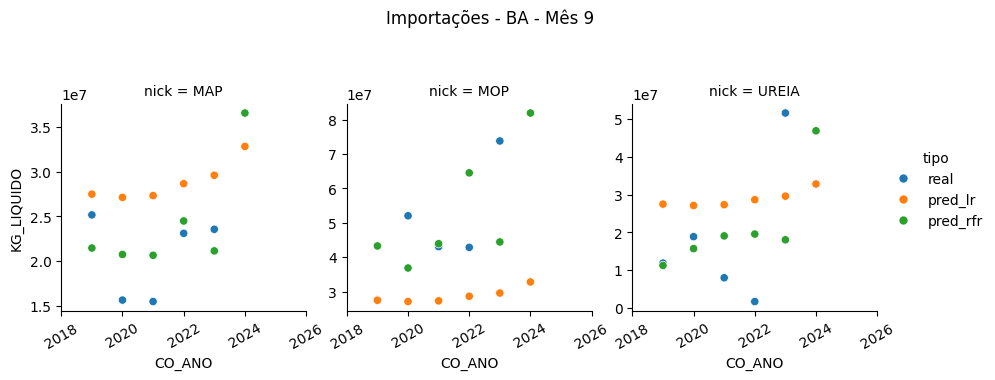

In [38]:
results=pd.concat([
    qq.drop(columns=['kg_test_rfr','kg_test_lr']).assign(tipo='real'),
    qq.drop(columns=['kg_test_rfr','kg']).rename(columns={'kg_test_lr':'kg'}).assign(tipo='test_lr'),
    qq.drop(columns=['kg','kg_test_lr']).rename(columns={'kg_test_rfr':'kg'}).assign(tipo='test_rfr'),
    pred.drop(columns=['kg_pred_lr']).rename(columns={'kg_pred_rfr':'kg'}).assign(tipo='pred_rfr'),
    pred.drop(columns=['kg_pred_rfr']).rename(columns={'kg_pred_lr':'kg'}).assign(tipo='pred_lr')
    
])

results.yaer=results.yaer.astype(int)

results.loc[results.tipo.str.contains('test'),'tipo']=results[results.tipo.str.contains('test')].tipo.str.replace('test','pred')

sns.relplot(data=results,x='yaer',y='kg',hue='tipo',col='Product',height=3,facet_kws={'sharey': False, 'sharex': True})\
.set_xticklabels(rotation=30).fig.suptitle(f"Importações - {UF[0]} - Mês {predict_date.month}",y=1.2)
plt.show()

In [39]:
time_end=time.time()
print(f"Duração: {round((time_end-time_ini)/20,1)} minutos.")

Duração: 2.8 minutos.
